# Análisis exploratorio de datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Se realiza un análisis exploratorio de los datos, con la finalidad de encontrar patrones que permitan generar información para la toma de decisiones en relación a los restaurantes existentes en los estados de **California**, **Texas**, **Florida**, **New York** & **Pennsylvania**.<br>
Para una lectura mas ordenada, los códigos de gráficos y otros datos se colocaron en funciones dentro de la librería `functions` que se adjunta en este repositorio.

### Importamos las librerias necesarias


In [2]:
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
import functions
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
# Descargamos los recursos necesarios para NLTK (solo es necesario la primera vez)
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Abrimos el archivo restaurant_clean <br>
Y vemos los primeros registros

In [4]:
df_rest_clean= pd.read_parquet('/content/drive/MyDrive/PF-Henry/google_restaurant_clean.parquet')

Vemos las columnas que hay en el dataset

In [5]:
df_rest_clean.columns

Index(['restaurant_name', 'address', 'state', 'city', 'postal_code',
       'latitude', 'longitude', 'avg_rating', 'num_of_reviews',
       'price_numeric', 'gmap_id'],
      dtype='object')

Modificamos el nombre de las columnas
- avg_rating por *avg_rating_rest*
- num_of_reviews por *num_of_reviews_rest*

In [6]:
df_rest_clean = df_rest_clean.rename(columns={'avg_rating':'avg_rating_rest',
                                      'num_of_reviews': 'num_of_reviews_rest'})

### Abrimos el archivo google_reviews <br>
Y vemos los primeros registros

In [7]:
df_reviews= pd.read_parquet('/content/drive/MyDrive/PF-Henry/google_reviews.parquet')


Vemos las columnas que hay en el dataset.

In [8]:
df_reviews.columns

Index(['user_id', 'user_name', 'time', 'rating', 'text', 'restaurant_name',
       'state', 'city', 'gmap_id'],
      dtype='object')

## Abrimos el archivo google_users <br>
Y vemos los primeros registros

In [9]:
df_users= pd.read_parquet('/content/drive/MyDrive/PF-Henry/google_users.parquet')


Vemos las columnas que hay en el dataset

In [10]:
df_users.columns

Index(['user_id', 'user_name', 'review_count', 'average_rating'], dtype='object')

### Eliminación de columnas <br>
Como se va a realizar una fusión de información entre los conjuntos de datos, se eliminan las columnas 'user_name', 'state', 'city' & ''gmap_id' del **df_reviews**, ya que tienen los mismos datos que en **df_rest_clean** y **df_users**

In [11]:
df_reviews = df_reviews.drop(['user_name', 'state', 'city', 'gmap_id'], axis=1)


## Fusión de información <br>
Unificamos los conjuntos de datos de *df_reviews* con *df_rest_clean* a través de **restaurant_name**

In [12]:
df_1= df_reviews.merge(df_rest_clean, on= 'restaurant_name', how= 'left')


Ahora unificamos los datos de *df_1* con *df_users* a través de **user_id**

In [13]:
df_google = df_1.merge(df_users, on= 'user_id', how= 'left')


In [14]:
df_google.columns

Index(['user_id', 'time', 'rating', 'text', 'restaurant_name', 'address',
       'state', 'city', 'postal_code', 'latitude', 'longitude',
       'avg_rating_rest', 'num_of_reviews_rest', 'price_numeric', 'gmap_id',
       'user_name', 'review_count', 'average_rating'],
      dtype='object')

Eliminamos columnas que no aportan valor. <br>
- average_rating
- review_count
- rating

In [15]:
df_google = df_google.drop(columns=['average_rating', 'review_count', 'rating'], axis=1)

Convertimos la columna **time** a tipo *datetime* para así poder obtener los datos de año, mes y día y trabajar de forma precisa

In [16]:
df_google['time'] = pd.to_datetime(df_google['time'])

Extraemos los datos de año, mes y día en columnas separadas, y se elimina la columna 'time'

In [17]:
df_google['year'] = df_google['time'].dt.year
df_google['month'] = df_google['time'].dt.month
df_google['day'] = df_google['time'].dt.day

In [18]:
df_google = df_google.drop(columns='time', axis=1)

Analizamos los datos de la columna **year**.

In [19]:
df_google.year.unique()

array([2013, 2015, 2014, 2016, 2017, 2021, 2020, 2019, 2010, 2012, 2009,
       2011, 2018, 2007, 2002, 2003, 2008, 2005, 2004, 2006, 1990])

Encontramos que hay registros de reseñas de años anteriores a 2016, por lo cual no son útiles para el análisis y se procede a eliminarlos.

In [20]:
df_google = df_google[df_google['year'].isin([2016, 2017, 2018, 2019, 2020, 2021])]

In [21]:
#Verificamos que se realizaron los cambios

df_google.year.unique()

array([2016, 2017, 2021, 2020, 2019, 2018])

Eliminamos las columnas **user_name**, **day** y **user_id**, ya que no aportan información valiosa para el análisis.

In [22]:
df_google = df_google.drop(columns=['user_name', 'day', 'user_id'], axis=1)

In [23]:
#Verificamos que se hayan eliminado correctamente las columnas.
df_google.columns

Index(['text', 'restaurant_name', 'address', 'state', 'city', 'postal_code',
       'latitude', 'longitude', 'avg_rating_rest', 'num_of_reviews_rest',
       'price_numeric', 'gmap_id', 'year', 'month'],
      dtype='object')

Podemos encontrar que hay definiciones de precios con valor 0(cero), lo cual no corresponde a las medidas reales de Google Maps.<br> Ya que representan menos del 10% del total, se procede a eliminarlas del conjunto de datos.

In [24]:
df_google['price_numeric'].value_counts()

1    19095551
0     1868598
2     1341649
3       39868
4        6562
Name: price_numeric, dtype: int64

In [25]:
df_google = df_google.query("price_numeric != 0")


### Creamos la columna de 'sentiment_analysis' en dfresenias_final, aplicando análisis de sentimiento con NLP calculando el puntaje de polaridad. <br>
### Cada puntaje queda representado con los siguientes valores:
- Muy negativo : 1
- Negativo: 2
- Neutral: 3
- Bueno: 4
- Muy bueno: 5


In [26]:
# Se crea el analizador de sentimientos una vez fuera de la función
sia = SentimentIntensityAnalyzer()

# Función para aplicar el análisis de sentimiento a un texto
def analyze_sentiment(text):
    if isinstance(text, str):
        compound_score = sia.polarity_scores(text)['compound']
        if compound_score >= 0.5:
            return 5
        elif compound_score >= 0:
            return 4
        elif compound_score >= -0.24:
            return 3
        elif compound_score >= -0.4:
            return 2
        else:
            return 1
    else:
        return 3  # Valor predeterminado si no es una cadena

# Vectorizar la función de análisis de sentimientos
vectorized_analyze_sentiment = np.vectorize(analyze_sentiment)

# Aplicar el análisis de sentimientos a la columna 'text'
df_google['sentiment_analysis'] = vectorized_analyze_sentiment(df_google['text'])

# Eliminar la columna 'text'
df_google.drop(columns=['text'], inplace=True)

### Cantidad de reseñas por año <br>
En este apartado, analizamos la cantidad de reseñas que hubo en cada año.

Cantidad de reseñas promedio por día: 9353


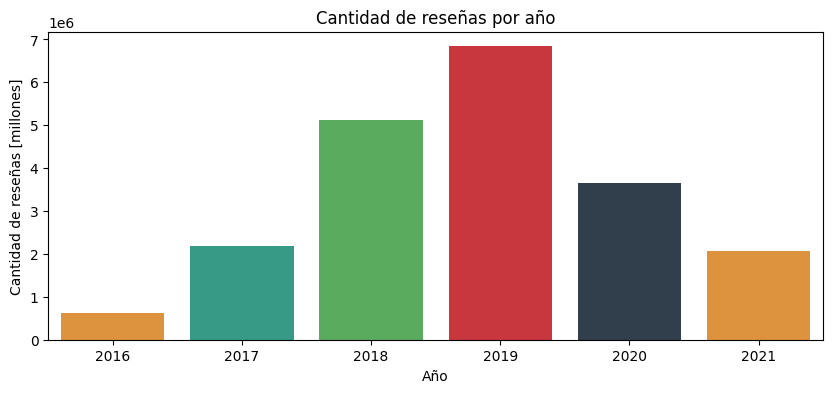

In [28]:
functions.reviews_por_año(df_google)

En el gráfico podemos ver que en el año **2019** se registra la mayor cantidad de reseñas y también se puede ver la disminución a partir del **2020**, provocada por la pandemia de COVID-19.

### Cantidad de reviews mensuales por año <br>
Visualizamos la cantidad de reviews registradas por cada mes, por cada año.

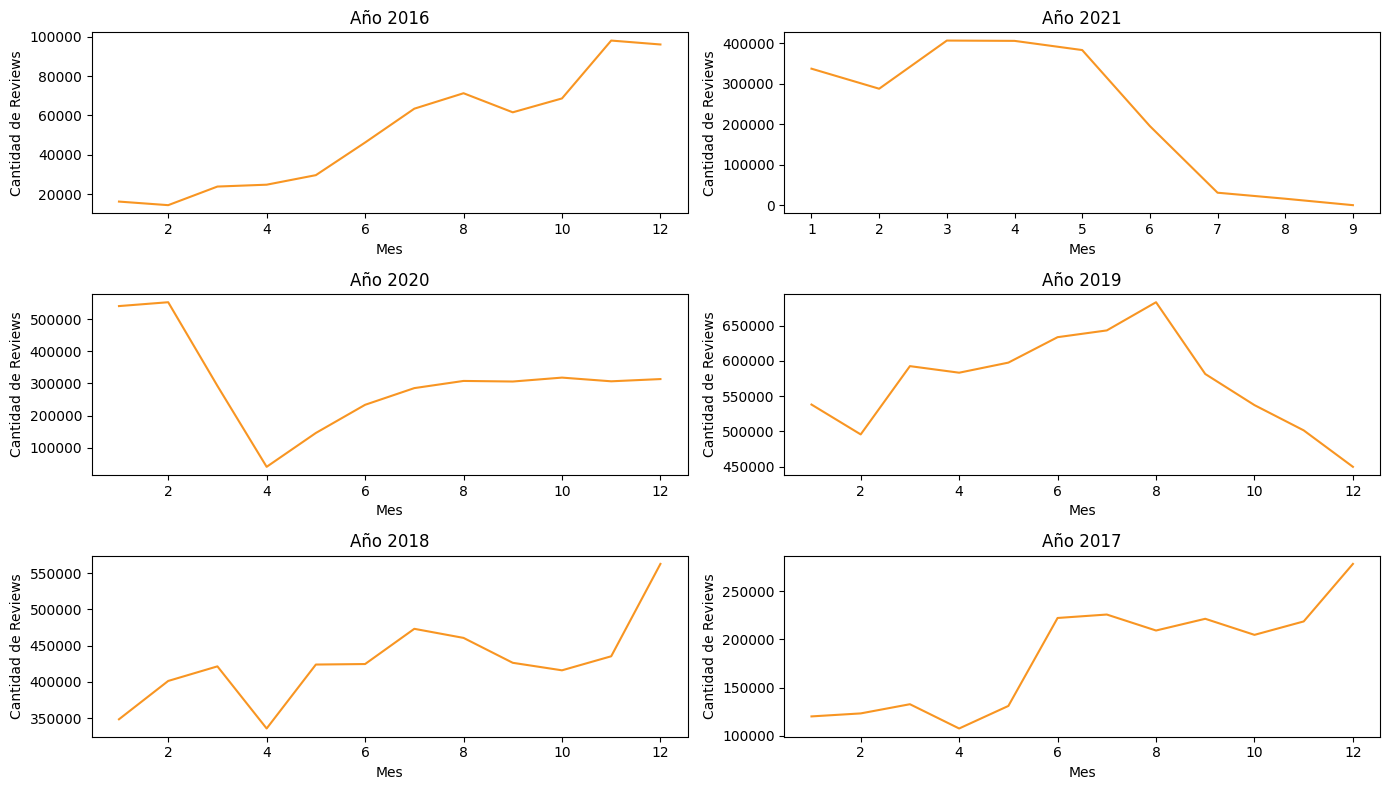

In [29]:

functions.reviews_mensuales(df_google)

En los gráficos no se observan patrones generales, pero si se puede observar una considerable disminución de registros desde febrero de 2020, esto debido a las restricciones impuestas por la cuarentena debido a la pandemia de COVID-19

### Cantidad de reviews por cada mes <br>
En este apartado analizamos las cantidad de reviews registradas por cada mes.

El mes con menor cantidad de reviews tiene 1498134 reviews
El mes con mayor cantidad de reviews tiene 1900301 reviews


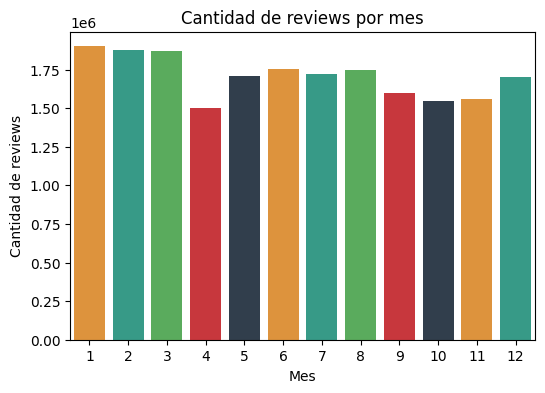

In [30]:
functions.cantidad_de_reviews_por_mes(df_google)

### Cantidad de restaurantes por estado <br>
En este apartado analizamos la cantidad de restaurantes en cada estado y el porcentaje que representan.


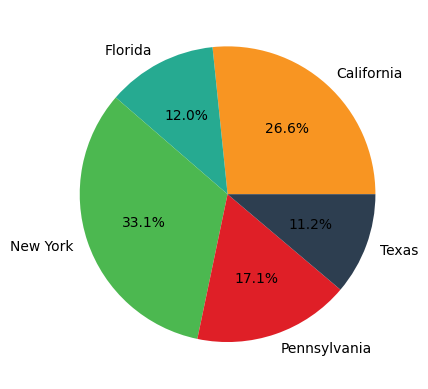

In [31]:
functions.restaurants_por_estado(df_google)

En el gráfico podemos observar que, entre New York y California, se concentran más del 50% de los restaurantes totales. Y que Texas es el estado con menor cantidad de restaurantes registrados.

### Cantidad de restaurantes por estado <br>
Analizamos la cantidad de restaurantes presentes en cada estado.

In [32]:
# Cuenta la cantidad de restaurantes únicos por estado.
count_by_state = df_google.groupby('state')['restaurant_name'].nunique()

count_by_state

state
California      2559
Florida         1156
New York        3179
Pennsylvania    1644
Texas           1074
Name: restaurant_name, dtype: int64

### Promedio de rating por estado <br>
En este apartado analizamos el promedio de rating de todos los restaurantes registrados en cada estado.<br>
<br>
Podemos obeservar que **California** tiene el mayor promedio de rating en cuanto a restaurantes.

In [33]:
functions.promedio_rating_reviews(df_google)

,state,avg_rating_rest
0,California,3.774632
1,Florida,3.667120
2,New York,3.698183
3,Pennsylvania,3.673308
4,Texas,3.657800


### Precios en cada estado.


En el siguiente apartado, analizamos cuál es el rango de precios más registrado en cada estado.

Total de registros para California y price_numeric 1: 5137093
Total de registros para California y price_numeric 2: 359318
Total de registros para California y price_numeric 3: 11221
Total de registros para California y price_numeric 4: 2094
Total de registros para Florida y price_numeric 1: 4634201
Total de registros para Florida y price_numeric 2: 350962
Total de registros para Florida y price_numeric 3: 14748
Total de registros para Florida y price_numeric 4: 1559
Total de registros para New York y price_numeric 1: 3581541
Total de registros para New York y price_numeric 2: 225316
Total de registros para New York y price_numeric 3: 10625
Total de registros para New York y price_numeric 4: 2826
Total de registros para Pennsylvania y price_numeric 1: 2166074
Total de registros para Pennsylvania y price_numeric 2: 136897
Total de registros para Pennsylvania y price_numeric 3: 1651
Total de registros para Pennsylvania y price_numeric 4: 58
Total de registros para Texas y price_numeric 1

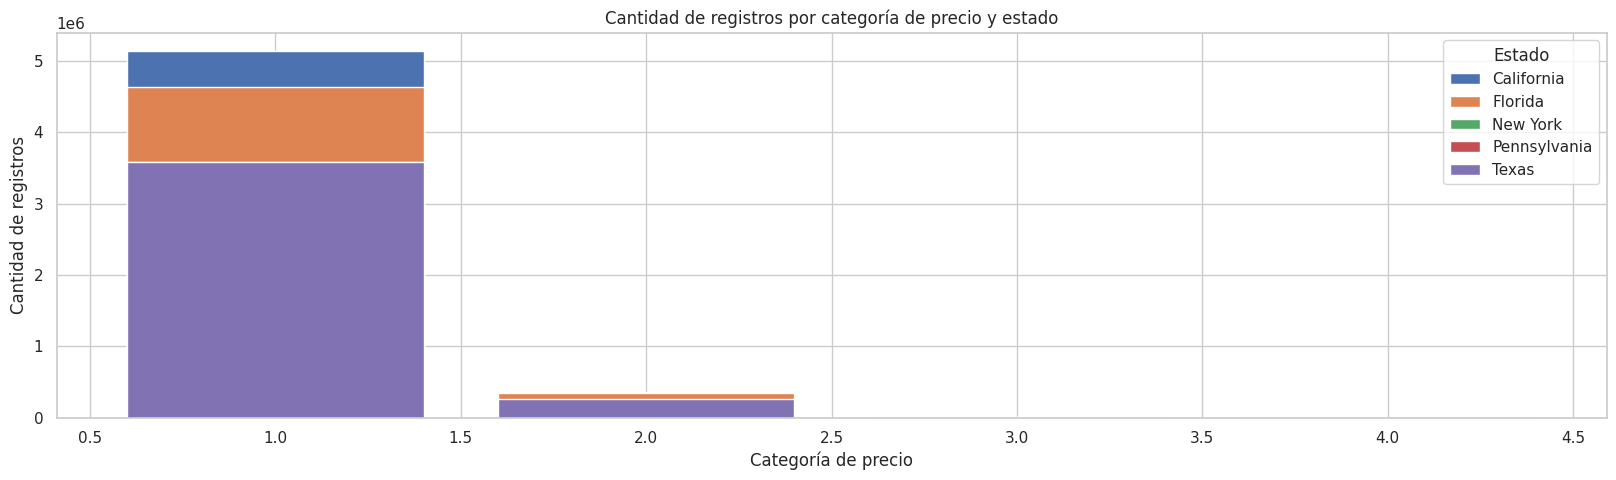

In [34]:
functions.precio_por_estado(df_google)

En el gráfico podemos observar que la gran mayoría de restaurantes, tienen una categoría de precios de **1**.<br> Tambien observamos que los restaurantes con categoria de precios **3** y **4**, son excesivamente pocos por lo cual no manejan precios tan elevados.